In [29]:
%matplotlib notebook

# Installa pybind11 e fai il binding con python

In [30]:
!pip install pybind11

Prendi file da repository HRNN per test.

In [31]:
import getCycles

In [32]:
!ls -ltr

total 1864
-rw-rw-r-- 1 gosti gosti    6025 nov  4  2019 getCycles.pyc
-rw-rw-r-- 1 gosti gosti   18959 nov  6  2019 picco-asym.png
-rw-r--r-- 1 gosti gosti      63 feb 28  2020 README.md
-rw-rw-r-- 1 gosti gosti    1166 nov 16  2020 multiprocessinRunRHNN.py
drwxrwxr-x 3 gosti gosti    4096 nov 16  2020 new
-rw-rw-r-- 1 gosti gosti   16631 dic  3  2020 getCyclesAsy.py
-rw-rw-r-- 1 gosti gosti   14821 dic  9  2020 getCycles.py
drwxrwxr-x 2 gosti gosti    4096 nov 26  2021 __pycache__
-rwxrwxr-x 1 gosti gosti  182608 dic 20 15:56 hrnn.cpython-37m-x86_64-linux-gnu.so
-rw-rw-r-- 1 gosti gosti     128 dic 20 15:56 single_hrnn_run.py
-rw-rw-r-- 1 gosti gosti    1138 dic 20 15:56 test1.py
-rw-rw-r-- 1 gosti gosti    1567 dic 20 15:58 test2.py
-rw-rw-r-- 1 gosti gosti     747 dic 20 15:59 newSim.ipynb
-rw-rw-r-- 1 gosti gosti 1609683 dic 20 16:00 HowToHRNN.ipynb
-rw-rw-r-- 1 gosti gosti   14766 dic 20 16:01 hrnn.cpp


# Compila shared lib

In [33]:
!c++ -O3 -Wall -shared -std=c++11 -fPIC -march=native `python3 -m pybind11 --includes` hrnn.cpp -o hrnn`python3-config --extension-suffix`

hrnn.cpp: In function ‘void ciclo_singola_matrice(double, double, double, mappa*, mappa*, mappa*, mappa*, mappa*, int, bool, double*)’:
hrnn.cpp:190:13: warning: unused variable ‘dist’ [-Wunused-variable]
         int dist[numStati];                   // Distanza dal C.L. degli stati
             ^~~~
hrnn.cpp: In function ‘pybind11::dict runRHNN(double, double, int)’:
hrnn.cpp:339:24: warning: ‘ptrNet’ may be used uninitialized in this function [-Wmaybe-uninitialized]
   ciclo_singola_matrice(eps, dil, thresh,
   ~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~
                         &isto_dist, &isto_lung, &isto_size, &isto_nclu, &isto_nvic,
                         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                         ripetiz, false, ptrNet);
                         ~~~~~~~~~~~~~~~~~~~~~~~


In [34]:
!head -n 40 hrnn.cpp


// Versione con ricerca sulle mappe (solo per mstati_di_mat, non per statim) e PARALLELIZZAZIONE BUONA

#include <pybind11/pybind11.h>
#include <pybind11/stl_bind.h>
#include <pybind11/numpy.h>

#include <cstdio>
#include <cstdlib>
#include <vector>
#include <array>
#include <ctime>
#include <map>
//#include <unordered_map>
#include <algorithm>
#include <iterator>
#include <fstream>
#include <iostream>
#include <iomanip>
#include <thread>
#include <future>
#include <mutex>
#include <assert.h>

#include <cmath>
#include <chrono>
#include <random>

#define HASH_MULT  314159    /* random multiplier */
#define HASH_PRIME 516595003 /* the 27182818th prime; it's $\leq 2^{29}$ */
#define N 14//5//14


using namespace std;

namespace py = pybind11;

using mappa = map<int, unsigned long long int>;

int show = 0;


In [17]:
ls -ltr

total 2000
-rw-rw-r-- 1 gosti gosti    6025 nov  4  2019 getCycles.pyc
-rw-rw-r-- 1 gosti gosti   18959 nov  6  2019 picco-asym.png
-rw-r--r-- 1 gosti gosti      63 feb 28  2020 README.md
-rw-rw-r-- 1 gosti gosti    1166 nov 16  2020 multiprocessinRunRHNN.py
drwxrwxr-x 3 gosti gosti    4096 nov 16  2020 new/
-rw-rw-r-- 1 gosti gosti   16631 dic  3  2020 getCyclesAsy.py
-rw-rw-r-- 1 gosti gosti   14821 dic  9  2020 getCycles.py
drwxrwxr-x 2 gosti gosti    4096 nov 26  2021 __pycache__/
-rw-rw-r-- 1 gosti gosti     128 nov 26  2021 single_hrnn_run.py
-rw-rw-r-- 1 gosti gosti    1567 dic 20 15:41 test2.py
-rw-rw-r-- 1 gosti gosti    1138 dic 20 15:43 test1.py
-rw-rw-r-- 1 gosti gosti 1752515 dic 20 15:50 HowToHRNN.ipynb
-rw-rw-r-- 1 gosti gosti   14769 dic 20 15:56 hrnn.cpp
-rwxrwxr-x 1 gosti gosti  182608 dic 20 15:56 hrnn.cpython-37m-x86_64-linux-gnu.so*


In [18]:
import hrnn

Testa run semplice del wraper cpp


In [19]:
%%writefile single_hrnn_run.py

import hrnn
import time

t1 = time.time()
dictMes = hrnn.runRHNN(0.0,0.0,2)#1000)
t2 = time.time()
print(dictMes)
print(t2-t1)

Overwriting single_hrnn_run.py


In [20]:
!python single_hrnn_run.py

N 5 eps 0.0 dil 0.0 ripetiz 2
{'Dist': nan, 'Size': 10.666666666666666, 'Lung': 2.0, 'NClu': 3.0}
6.151199340820312e-05


In [21]:
!python single_hrnn_run.py

N 5 eps 0.0 dil 0.0 ripetiz 2
{'Dist': nan, 'Size': 10.666666666666666, 'Lung': 2.0, 'NClu': 3.0}
6.341934204101562e-05


# Test 1 rete simmetrica

In [22]:
%%writefile test1.py

import hrnn
import time
import numpy as np
import getCycles

net = [[0.0000000E+0000, - 0.5171256E+0000, -0.2989531E-0001, -0.7808704E+0000, 0.7945437E+0000],
      [-0.5171256E+0000, 0.0000000E+0000, -0.2580485E+0000, -0.6977754E+0000, -0.8953681E+0000],
      [-0.2989531E-0001, -0.2580485E+0000, 0.0000000E+0000, 0.8754015E+0000, 0.9808731E+0000],
      [-0.7808704E+0000, -0.6977754E+0000, 0.8754015E+0000, 0.0000000E+0000, -0.1136637E+0000],
      [0.7945437E+0000, -0.8953681E+0000, 0.9808731E+0000, -0.1136637E+0000, 0.0000000E+0000]]

net = np.array(net).T
#net = getCycles.get_connectivity_matrix(9999, 14,0.0,0.0)
print(net)
print(net.shape)
nets = np.array([net.T])
print(nets.shape)

t1 = time.time()
cycles = getCycles.getCyclesNX(net, net.shape[0], 0, 0)
t2 = time.time()
print('time pyton',t2-t1)
print('cycles python',cycles[0])



t1 = time.time()
#nets = np.ones((4,14,14))
print(nets)
dictMes = hrnn.runRHNNwithNets(0.0,nets)
t2 = time.time()
print(dictMes)
print('time cpp',t2-t1)

print('cycles python',len(cycles[0]), 'cycles cpp',int(dictMes['NClu']))
print('Test result ', len(cycles[0]) == int(dictMes['NClu']))


Overwriting test1.py


In [23]:
!python test1.py

[[ 0.         -0.5171256  -0.02989531 -0.7808704   0.7945437 ]
 [-0.5171256   0.         -0.2580485  -0.6977754  -0.8953681 ]
 [-0.02989531 -0.2580485   0.          0.8754015   0.9808731 ]
 [-0.7808704  -0.6977754   0.8754015   0.         -0.1136637 ]
 [ 0.7945437  -0.8953681   0.9808731  -0.1136637   0.        ]]
(5, 5)
(1, 5, 5)
time pyton 0.32760190963745117
cycles python [[21], [7], [8], [3, 20], [5, 23]]
[[[ 0.         -0.5171256  -0.02989531 -0.7808704   0.7945437 ]
  [-0.5171256   0.         -0.2580485  -0.6977754  -0.8953681 ]
  [-0.02989531 -0.2580485   0.          0.8754015   0.9808731 ]
  [-0.7808704  -0.6977754   0.8754015   0.         -0.1136637 ]
  [ 0.7945437  -0.8953681   0.9808731  -0.1136637   0.        ]]]
N 5
Np 5
Npp 5
ripetiz 1
N 5 thresh 0.0 ripetiz 1
{'Dist': nan, 'Size': 6.4, 'Lung': 1.6, 'NClu': 5.0}
time cpp 0.0004286766052246094
cycles python 5 cycles cpp 5
Test result  True


# Test 2 rete asimmetrica

In [24]:
%%writefile test2.py

import hrnn
import time
import numpy as np
import getCycles

net = [[0.000000000000000000000000E+0000, 0.350680351257324218750000E-0001, 0.638692855834960937500000E+0000, -0.755703926086425781250000E+0000, -0.619309902191162109375000E+0000],
          [-0.392206668853759765625000E+0000, 0.000000000000000000000000E+0000, -0.483913183212280273437500E+0000, 0.251545906066894531250000E-0001, 0.710200786590576171875000E+0000],
          [0.159279346466064453125000E+0000, -0.138426065444946289062500E+0000, 0.000000000000000000000000E+0000, 0.598297119140625000000000E-0001, 0.119009733200073242187500E+0000],
          [0.151961803436279296875000E+0000, -0.474640369415283203125000E+0000, 0.674424648284912109375000E+0000, 0.000000000000000000000000E+0000, 0.402131080627441406250000E-0001],
          [0.745916366577148437500000E-0002, -0.261993408203125000000000E+0000, - 0.740401744842529296875000E-0001, 0.243728160858154296875000E+0000, 0.000000000000000000000000E+0000]]

net = np.array(net).T
#net = getCycles.get_connectivity_matrix(9999, 14,0.0,0.0)
print(net)
print(net.shape)
nets = np.array([net.T])
print(nets.shape)

t1 = time.time()
cycles = getCycles.getCyclesNX(net, net.shape[0], 0, 0)
t2 = time.time()
print('time pyton',t2-t1)
print(cycles)



t1 = time.time()
#nets = np.ones((4,14,14))
print(nets)
dictMes = hrnn.runRHNNwithNets(0.0,nets)
t2 = time.time()
print(dictMes)
print(t2-t1)
print('time cpp',t2-t1)

print('cycles python',len(cycles[0]), 'cycles cpp',int(dictMes['NClu']))
print('Test result ', len(cycles[0]) == int(dictMes['NClu']))


Overwriting test2.py


In [25]:
!python test2.py

[[ 0.         -0.39220667  0.15927935  0.1519618   0.00745916]
 [ 0.03506804  0.         -0.13842607 -0.47464037 -0.26199341]
 [ 0.63869286 -0.48391318  0.          0.67442465 -0.07404017]
 [-0.75570393  0.02515459  0.05982971  0.          0.24372816]
 [-0.6193099   0.71020079  0.11900973  0.04021311  0.        ]]
(5, 5)
(1, 5, 5)
time pyton 0.3305366039276123
([[20]], <networkx.classes.digraph.DiGraph object at 0x7fc37e0b1990>)
[[[ 0.          0.03506804  0.63869286 -0.75570393 -0.6193099 ]
  [-0.39220667  0.         -0.48391318  0.02515459  0.71020079]
  [ 0.15927935 -0.13842607  0.          0.05982971  0.11900973]
  [ 0.1519618  -0.47464037  0.67442465  0.          0.04021311]
  [ 0.00745916 -0.26199341 -0.07404017  0.24372816  0.        ]]]
N 5
Np 5
Npp 5
ripetiz 1
N 5 thresh 0.0 ripetiz 1
{'Dist': nan, 'Size': 32.0, 'Lung': 2.0, 'NClu': 1.0}
0.0003807544708251953
time cpp 0.0003807544708251953
cycles python 1 cycles cpp 1
Test result  True


# Esempio di profilo

N 14 eps 1.0 dil 0.0 ripetiz 100
{'Dist': nan, 'Size': 5461.333333333333, 'Lung': 5.333333333333333, 'NClu': 3.0}
N 14 eps 1.0 dil 0.010101010101010102 ripetiz 100
{'Dist': nan, 'Size': 5461.333333333333, 'Lung': 5.333333333333333, 'NClu': 3.0}
N 14 eps 1.0 dil 0.020202020202020204 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 10.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.030303030303030304 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 14.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.04040404040404041 ripetiz 100
{'Dist': nan, 'Size': 3276.8, 'Lung': 2.6, 'NClu': 5.0}
N 14 eps 1.0 dil 0.05050505050505051 ripetiz 100
{'Dist': nan, 'Size': 8192.0, 'Lung': 7.5, 'NClu': 2.0}
N 14 eps 1.0 dil 0.06060606060606061 ripetiz 100
{'Dist': nan, 'Size': 5461.333333333333, 'Lung': 4.333333333333333, 'NClu': 3.0}
N 14 eps 1.0 dil 0.07070707070707072 ripetiz 100
{'Dist': nan, 'Size': 8192.0, 'Lung': 5.0, 'NClu': 2.0}
N 14 eps 1.0 dil 0.08080808080808081 ripetiz 100
{'Dist': nan, 'Size': 5461.333333333333, 'Lun

{'Dist': nan, 'Size': 2730.6666666666665, 'Lung': 1.8333333333333333, 'NClu': 6.0}
N 14 eps 1.0 dil 0.7777777777777778 ripetiz 100
{'Dist': nan, 'Size': 2730.6666666666665, 'Lung': 1.8333333333333333, 'NClu': 6.0}
N 14 eps 1.0 dil 0.787878787878788 ripetiz 100
{'Dist': nan, 'Size': 2730.6666666666665, 'Lung': 1.8333333333333333, 'NClu': 6.0}
N 14 eps 1.0 dil 0.797979797979798 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 2.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.8080808080808082 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 4.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.8181818181818182 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 3.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.8282828282828284 ripetiz 100
{'Dist': nan, 'Size': 5461.333333333333, 'Lung': 2.6666666666666665, 'NClu': 3.0}
N 14 eps 1.0 dil 0.8383838383838385 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 4.0, 'NClu': 1.0}
N 14 eps 1.0 dil 0.8484848484848485 ripetiz 100
{'Dist': nan, 'Size': 16384.0, 'Lung': 3.0, 'NClu': 1.0}
N 

<IPython.core.display.Javascript object>


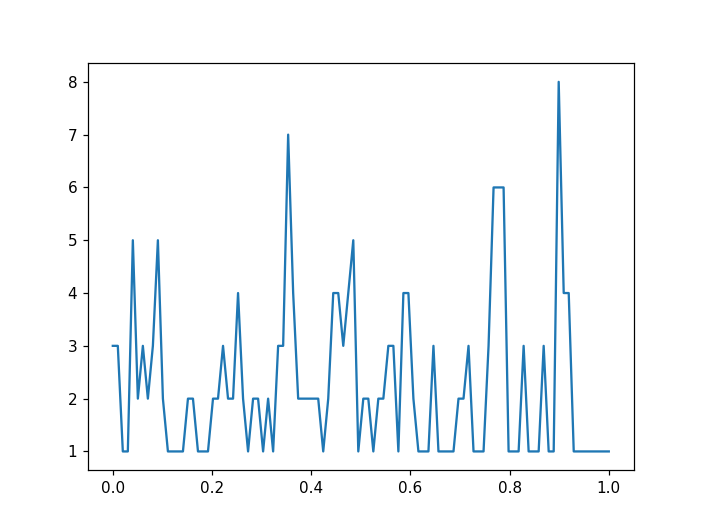

<IPython.core.display.Javascript object>


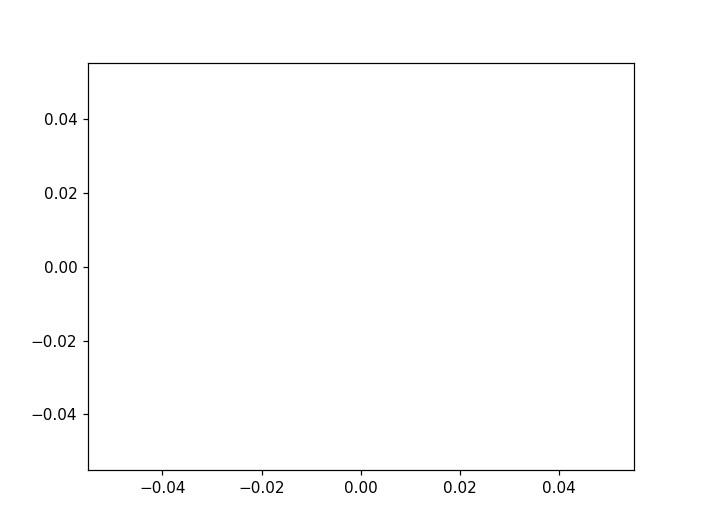

In [13]:
import hrnn
import time
import numpy as np
import matplotlib.pyplot as plt

C = []
D = []
t1 = time.time()
rhos = np.linspace(0.0, 1.0, num=100)
for rho in rhos:
    dictMes = hrnn.runRHNN(1.0,rho,100)
    print(dictMes)
    C.append(dictMes['NClu'])
    D.append(dictMes['Dist'])
t2 = time.time()
print('time',t2-t1)


plt.figure()
plt.plot(rhos,C)

plt.figure()
plt.plot(rhos,D)

# Esempio di profilo con matrici generate in python 
Ricorda di ricompilare con N=14 il file cpp

rho 0.0
rho 0.001001001001001001
rho 0.002002002002002002
rho 0.003003003003003003
rho 0.004004004004004004
rho 0.005005005005005005
rho 0.006006006006006006
rho 0.007007007007007007
rho 0.008008008008008008
rho 0.009009009009009009
rho 0.01001001001001001
rho 0.011011011011011011
rho 0.012012012012012012
rho 0.013013013013013013
rho 0.014014014014014014
rho 0.015015015015015015
rho 0.016016016016016016
rho 0.017017017017017015
rho 0.018018018018018018
rho 0.01901901901901902
rho 0.02002002002002002
rho 0.02102102102102102
rho 0.022022022022022022
rho 0.023023023023023025
rho 0.024024024024024024
rho 0.025025025025025023
rho 0.026026026026026026
rho 0.02702702702702703
rho 0.028028028028028028
rho 0.029029029029029027
rho 0.03003003003003003
rho 0.031031031031031032
rho 0.03203203203203203
rho 0.03303303303303303
rho 0.03403403403403403
rho 0.035035035035035036
rho 0.036036036036036036
rho 0.037037037037037035
rho 0.03803803803803804
rho 0.03903903903903904
rho 0.04004004004004004
rho 

rho 0.34634634634634637
rho 0.34734734734734735
rho 0.3483483483483483
rho 0.34934934934934936
rho 0.35035035035035034
rho 0.35135135135135137
rho 0.35235235235235235
rho 0.3533533533533533
rho 0.35435435435435436
rho 0.35535535535535534
rho 0.3563563563563564
rho 0.35735735735735735
rho 0.35835835835835833
rho 0.35935935935935936
rho 0.36036036036036034
rho 0.3613613613613614
rho 0.36236236236236236
rho 0.36336336336336333
rho 0.36436436436436437
rho 0.36536536536536535
rho 0.3663663663663664
rho 0.36736736736736736
rho 0.3683683683683684
rho 0.36936936936936937
rho 0.37037037037037035
rho 0.3713713713713714
rho 0.37237237237237236
rho 0.3733733733733734
rho 0.3743743743743744
rho 0.37537537537537535
rho 0.3763763763763764
rho 0.37737737737737737
rho 0.3783783783783784
rho 0.3793793793793794
rho 0.38038038038038036
rho 0.3813813813813814
rho 0.38238238238238237
rho 0.3833833833833834
rho 0.3843843843843844
rho 0.38538538538538536
rho 0.3863863863863864
rho 0.38738738738738737
rho 0.38

rho 0.7007007007007007
rho 0.7017017017017017
rho 0.7027027027027027
rho 0.7037037037037037
rho 0.7047047047047047
rho 0.7057057057057057
rho 0.7067067067067067
rho 0.7077077077077077
rho 0.7087087087087087
rho 0.7097097097097097
rho 0.7107107107107107
rho 0.7117117117117117
rho 0.7127127127127127
rho 0.7137137137137137
rho 0.7147147147147147
rho 0.7157157157157157
rho 0.7167167167167167
rho 0.7177177177177178
rho 0.7187187187187187
rho 0.7197197197197197
rho 0.7207207207207207
rho 0.7217217217217217
rho 0.7227227227227228
rho 0.7237237237237237
rho 0.7247247247247247
rho 0.7257257257257257
rho 0.7267267267267267
rho 0.7277277277277278
rho 0.7287287287287287
rho 0.7297297297297297
rho 0.7307307307307307
rho 0.7317317317317317
rho 0.7327327327327328
rho 0.7337337337337337
rho 0.7347347347347347
rho 0.7357357357357357
rho 0.7367367367367368
rho 0.7377377377377378
rho 0.7387387387387387
rho 0.7397397397397397
rho 0.7407407407407407
rho 0.7417417417417418
rho 0.7427427427427428
rho 0.74374

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
1.0 (1000, 14, 14)
N 14
Np 14
Npp 14
ripetiz 1000
N 

<IPython.core.display.Javascript object>


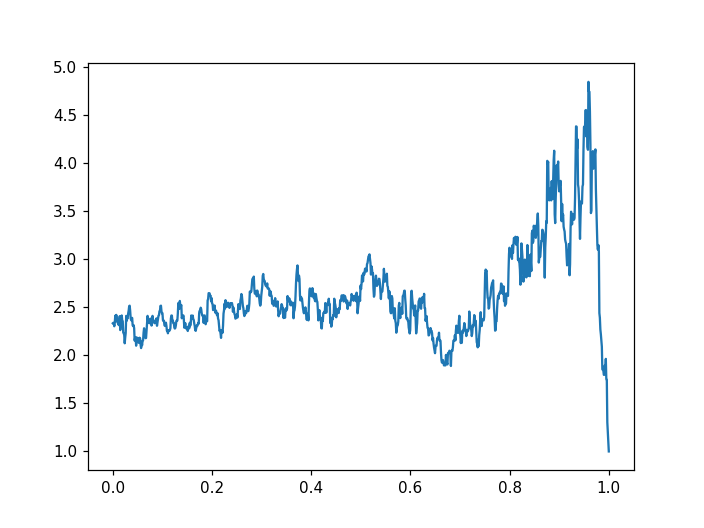

<IPython.core.display.Javascript object>


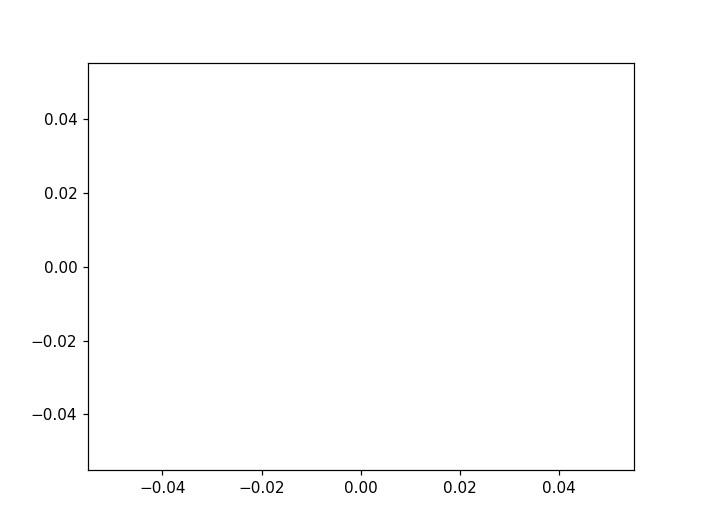

In [36]:
import hrnn
import time
import numpy as np
import matplotlib.pyplot as plt
import getCycles

N = 14
runNum = 1000
seed = 8888#int(np.random.rand() * 10000)
np.random.seed(seed)
rhos = np.linspace(0.0, 1.0, num=1000) 

C = []
D = []
t1 = time.time()


# genera le matrici di connettività
rhosNets = []

for rho in rhos:
    print('rho',rho)
    numLoops = []
    nets = []
    for run in range(runNum):
        #print('seed',seed)
        #print(run)
        rseed = np.random.choice(1000)
        #C = get_connectivity_matrix(seed,N=N,rho=rho,epsilon=1.0)
        #net = getCycles.get_connectivity_matrix_fortranStyle(N=N,rho=rho,epsilon=1.0)
        net = getCycles.get_connectivity_matrix(N=N,rho=rho,epsilon=1.0,my_seed=rseed)
        nets.append(net.T)
    nets = np.array(nets)
    rhosNets.append(nets)
t2 = time.time()


for nets in rhosNets:
    print(rho,nets.shape)
    dictMes = hrnn.runRHNNwithNets(0.0,nets)
    #print(dictMes)
    C.append(dictMes['NClu'])
    D.append(dictMes['Dist'])
t3 = time.time()

print('time generate nets',t2-t1)
print('time hrnn run ',t3-t2)


plt.figure()
plt.plot(rhos,C)

plt.figure()
plt.plot(rhos,D)

# Versione multiprocessin

In [ ]:
import hrnn
import time
import numpy as np
import matplotlib.pyplot as plt
import getCycles
from multiprocessing import Pool

def runRHNN(nets):
    dictMes = hrnn.runRHNNwithNets(0.0,nets)
    return dictMes['NClu'],dictMes['Dist']

if __name__ == '__main__':
  p = Pool(8)
  N = 14
  runNum = 1000
  seed = 8889#int(np.random.rand() * 10000)
  np.random.seed(seed)
  rhos = np.linspace(0.0, 1.0, num=100) 

  t1 = time.time()

  rhosNets = []

  for rho in rhos:
    print('rho',rho)
    numLoops = []
    nets = []
    for run in range(runNum):
      #print 'seed',seed
      #C = get_connectivity_matrix(seed,N=N,rho=rho,epsilon=1.0)
      net = getCycles.get_connectivity_matrix_fortranStyle(N=N,rho=rho,epsilon=1.0)
      #net = getCycles.get_connectivity_matrix(N=N,rho=rho,epsilon=1.0,my_seed=rseed)
      nets.append(net.T)
    nets = np.array(nets)
    rhosNets.append(nets)
  t2 = time.time()


  CsDs = p.map(runRHNN,rhosNets)
  t3 = time.time()

  C = []
  D = []
  for c,d in CsDs:
    C.append(c)
    D.append(d)
  t4 = time.time() 
  print('time generate nets',t2-t1)
  print('time hrnn run ',t3-t2)
  print('time format data ',t4-t3)
  
  plt.figure()
  plt.xlabel('rho')
  plt.ylabel('C')
  plt.plot(rhos,C)

  plt.figure()
  plt.plot(rhos,D)
  plt.xlabel('rho')
  plt.ylabel('D')

rho 0.0
rho 0.010101010101010102
rho 0.020202020202020204
rho 0.030303030303030304
rho 0.04040404040404041
rho 0.05050505050505051
rho 0.06060606060606061
rho 0.07070707070707072
rho 0.08080808080808081
rho 0.09090909090909091
rho 0.10101010101010102
rho 0.11111111111111112
rho 0.12121212121212122
rho 0.13131313131313133
rho 0.14141414141414144
rho 0.15151515151515152
rho 0.16161616161616163
rho 0.17171717171717174
rho 0.18181818181818182
rho 0.19191919191919193
rho 0.20202020202020204
rho 0.21212121212121213
rho 0.22222222222222224
rho 0.23232323232323235
rho 0.24242424242424243
rho 0.25252525252525254
rho 0.26262626262626265
rho 0.27272727272727276
rho 0.2828282828282829
rho 0.29292929292929293
rho 0.30303030303030304
rho 0.31313131313131315
rho 0.32323232323232326
rho 0.33333333333333337
rho 0.3434343434343435
rho 0.3535353535353536
rho 0.36363636363636365
rho 0.37373737373737376
rho 0.38383838383838387
rho 0.393939393939394
rho 0.4040404040404041
rho 0.4141414141414142
rho 0.424242

<IPython.core.display.Javascript object>


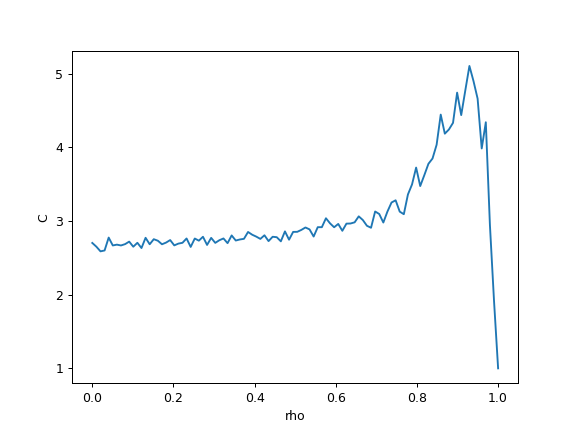

<IPython.core.display.Javascript object>


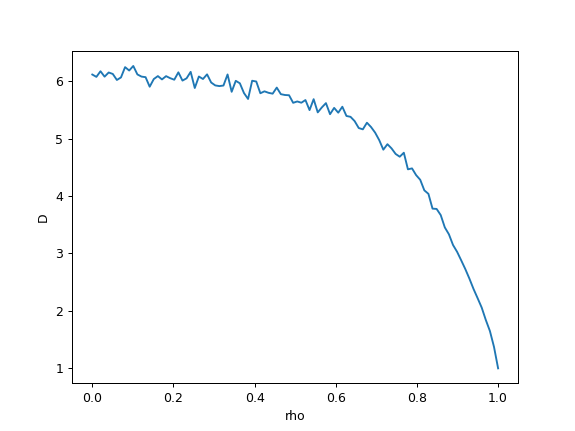

<IPython.core.display.Javascript object>


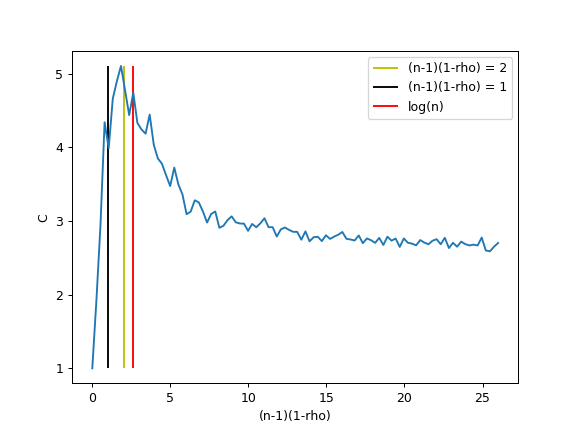

<IPython.core.display.Javascript object>


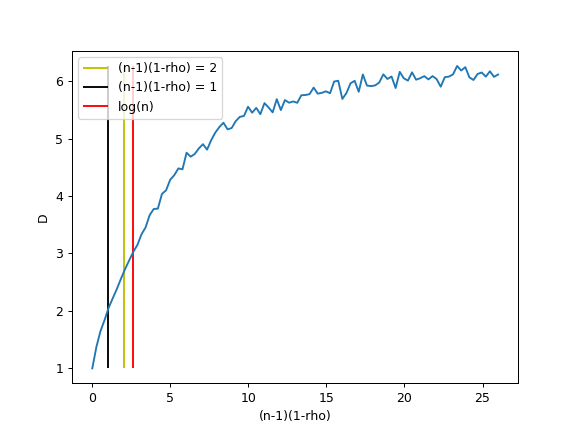

In [40]:
plt.figure()
plt.xlabel('rho')
plt.ylabel('C')
plt.plot(rhos,C)

plt.figure()
plt.plot(rhos,D)
plt.xlabel('rho')
plt.ylabel('D')


plt.figure()
plt.plot(2*(N-1)*(1-rhos),C)
plt.vlines(2,ymin=min(C),ymax=max(C),color='y',label='(n-1)(1-rho) = 2')
plt.vlines(1,ymin=min(C),ymax=max(C),label='(n-1)(1-rho) = 1')
plt.vlines(np.log(N),ymin=min(C),ymax=max(C),color='r',label='log(n)')
plt.xlabel('(n-1)(1-rho)')
plt.ylabel('C')
plt.legend()

plt.figure()
plt.plot(2*(N-1)*(1-rhos),D)
plt.vlines(2,ymin=min(D),ymax=max(D),color='y',label='(n-1)(1-rho) = 2')
plt.vlines(1,ymin=min(D),ymax=max(D),label='(n-1)(1-rho) = 1')
plt.vlines(np.log(N),ymin=min(D),ymax=max(D),color='r',label='log(n)')
plt.xlabel('(n-1)(1-rho)')
plt.ylabel('D')
plt.legend()

rho 0.0
rho 0.010101010101010102
rho 0.020202020202020204
rho 0.030303030303030304
rho 0.04040404040404041
rho 0.05050505050505051
rho 0.06060606060606061
rho 0.07070707070707072
rho 0.08080808080808081
rho 0.09090909090909091
rho 0.10101010101010102
rho 0.11111111111111112
rho 0.12121212121212122
rho 0.13131313131313133
rho 0.14141414141414144
rho 0.15151515151515152
rho 0.16161616161616163
rho 0.17171717171717174
rho 0.18181818181818182
rho 0.19191919191919193
rho 0.20202020202020204
rho 0.21212121212121213
rho 0.22222222222222224
rho 0.23232323232323235
rho 0.24242424242424243
rho 0.25252525252525254
rho 0.26262626262626265
rho 0.27272727272727276
rho 0.2828282828282829
rho 0.29292929292929293
rho 0.30303030303030304
rho 0.31313131313131315
rho 0.32323232323232326
rho 0.33333333333333337
rho 0.3434343434343435
rho 0.3535353535353536
rho 0.36363636363636365
rho 0.37373737373737376
rho 0.38383838383838387
rho 0.393939393939394
rho 0.4040404040404041
rho 0.4141414141414142
rho 0.424242

<IPython.core.display.Javascript object>


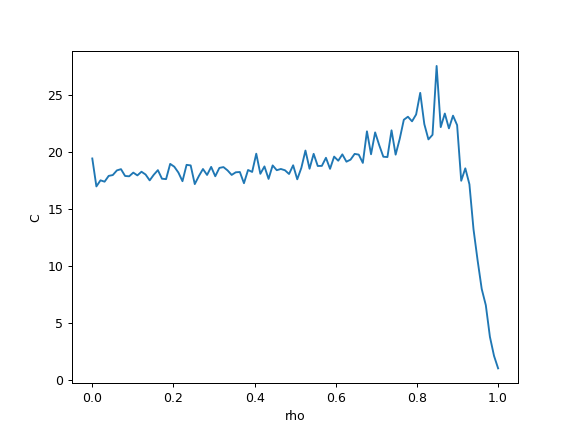

<IPython.core.display.Javascript object>


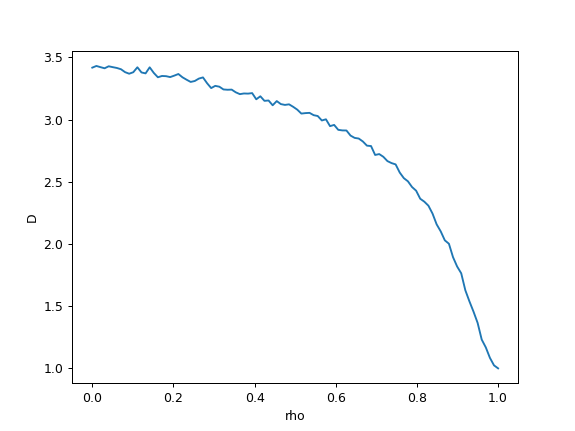

In [22]:
import hrnn
import time
import numpy as np
import matplotlib.pyplot as plt
import getCycles
from multiprocessing import Pool

def runRHNN(nets):
    dictMes = hrnn.runRHNNwithNets(0.0,nets)
    return dictMes['NClu'],dictMes['Dist']

if __name__ == '__main__':
  p = Pool(8)
  N = 14
  runNum = 1000
  seed = 8889#int(np.random.rand() * 10000)
  np.random.seed(seed)
  rhos = np.linspace(0.0, 1.0, num=100) 

  t1 = time.time()

  rhosNets = []

  for rho in rhos:
    print('rho',rho)
    numLoops = []
    nets = []
    for run in range(runNum):
      #print 'seed',seed
      #C = get_connectivity_matrix(seed,N=N,rho=rho,epsilon=1.0)
      net = getCycles.get_connectivity_matrix_fortranStyle(N=N,rho=rho,epsilon=0.0)
      #net = getCycles.get_connectivity_matrix(N=N,rho=rho,epsilon=1.0,my_seed=rseed)
      nets.append(net.T)
    nets = np.array(nets)
    rhosNets.append(nets)
  t2 = time.time()


  CsDs = p.map(runRHNN,rhosNets)
  t3 = time.time()
  print('time hrnn run ',t3-t2)

  C = []
  D = []
  for c,d in CsDs:
    C.append(c)
    D.append(d)
  t4 = time.time() 
  print('time generate nets',t2-t1)
  print('time hrnn run ',t3-t2)
  print('time format data ',t4-t3)
  
  plt.figure()
  plt.xlabel('rho')
  plt.ylabel('C')
  plt.plot(rhos,C)

  plt.figure()
  plt.plot(rhos,D)
  plt.xlabel('rho')
  plt.ylabel('D')

<IPython.core.display.Javascript object>


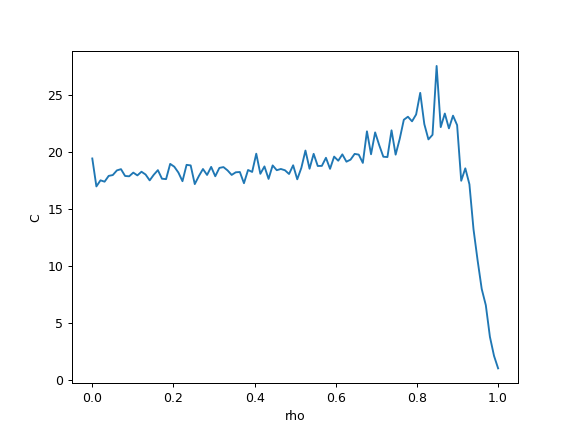

<IPython.core.display.Javascript object>


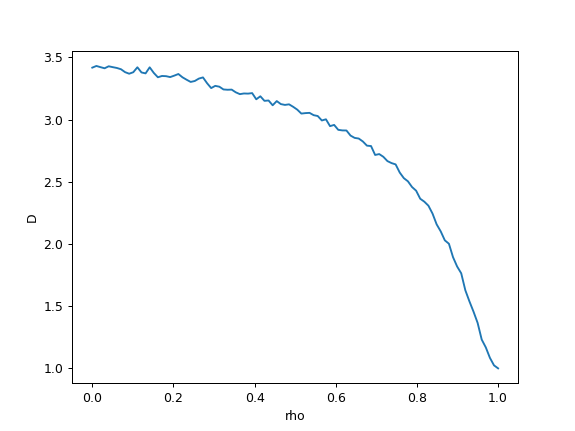

<IPython.core.display.Javascript object>


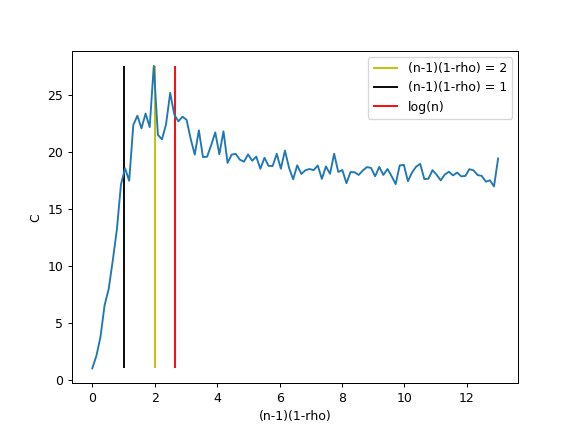

<IPython.core.display.Javascript object>


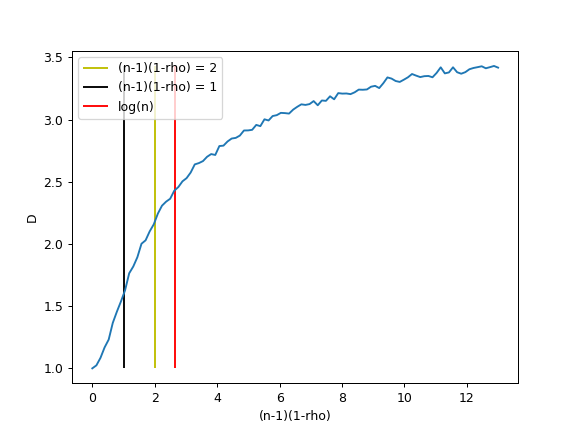

In [37]:
plt.figure()
plt.xlabel('rho')
plt.ylabel('C')
plt.plot(rhos,C)

plt.figure()
plt.plot(rhos,D)
plt.xlabel('rho')
plt.ylabel('D')


plt.figure()
plt.plot((N-1)*(1-rhos),C)
plt.vlines(2,ymin=min(C),ymax=max(C),color='y',label='(n-1)(1-rho) = 2')
plt.vlines(1,ymin=min(C),ymax=max(C),label='(n-1)(1-rho) = 1')
plt.vlines(np.log(N),ymin=min(C),ymax=max(C),color='r',label='log(n)')
plt.xlabel('(n-1)(1-rho)')
plt.ylabel('C')
plt.legend()

plt.figure()
plt.plot((N-1)*(1-rhos),D)
plt.vlines(2,ymin=min(D),ymax=max(D),color='y',label='(n-1)(1-rho) = 2')
plt.vlines(1,ymin=min(D),ymax=max(D),label='(n-1)(1-rho) = 1')
plt.vlines(np.log(N),ymin=min(D),ymax=max(D),color='r',label='log(n)')
plt.xlabel('(n-1)(1-rho)')
plt.ylabel('D')
plt.legend()

rho 0.0
rho 0.05263157894736842
rho 0.10526315789473684
rho 0.15789473684210525
rho 0.21052631578947367
rho 0.2631578947368421
rho 0.3157894736842105
rho 0.3684210526315789
rho 0.42105263157894735
rho 0.47368421052631576
rho 0.5263157894736842
rho 0.5789473684210527
rho 0.631578947368421
rho 0.6842105263157894
rho 0.7368421052631579
rho 0.7894736842105263
rho 0.8421052631578947
rho 0.894736842105263
rho 0.9473684210526315
rho 1.0
N 14
Np 14
ripetiz 1000
N 14
Np 14
N 14 thresh 0.0 ripetiz 1000
ripetiz 1000
N 14
N 14 thresh 0.0 ripetiz 1000
Np 14
ripetiz 1000
N 14
N 14
Np 14
ripetiz 1000
Np 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
N 14 thresh 0.0 ripetiz 1000
Np 14
N 14 thresh 0.0 ripetiz 1000
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
Np 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
Np 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
Np 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
Np 14
ripetiz 1000
N 14 thresh 0.0 ripetiz 1000
N 14
Np 14
ripetiz 1000
N 14 thresh 

<IPython.core.display.Javascript object>


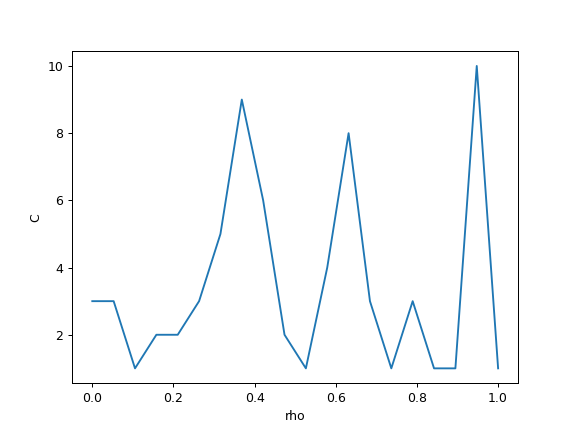

<IPython.core.display.Javascript object>


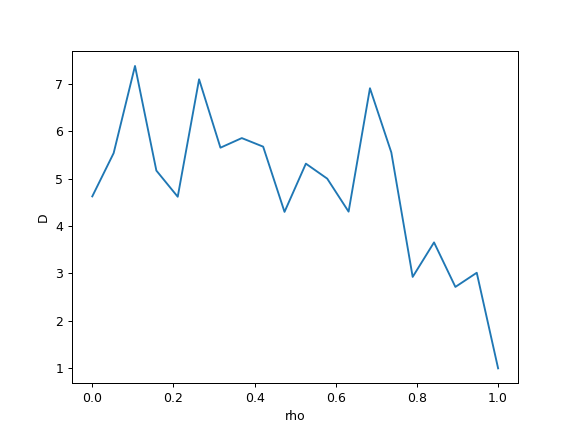

In [16]:
import hrnn
import time
import numpy as np
import matplotlib.pyplot as plt
import getCycles
from multiprocessing import Pool

def runRHNN(nets):
    dictMes = hrnn.runRHNNwithNets(0.0,nets)
    return dictMes['NClu'],dictMes['Dist']

if __name__ == '__main__':
  p = Pool(6)
  N = 14
  runNum = 1000
  seed = 8889#int(np.random.rand() * 10000)
  np.random.seed(seed)
  rhos = np.linspace(0.0, 1.0, num=20) 

  t1 = time.time()

  rhosNets = []

  for rho in rhos:
    print('rho',rho)
    numLoops = []
    nets = []
    for run in range(runNum):
      #print 'seed',seed
      #C = get_connectivity_matrix(seed,N=N,rho=rho,epsilon=1.0)
      #net = getCycles.get_connectivity_matrix_fortranStyle(N=N,rho=rho,epsilon=1.0)
      net = getCycles.get_connectivity_matrix(N=N,rho=rho,epsilon=1.0,my_seed=rseed)
      nets.append(net.T)
    nets = np.array(nets)
    rhosNets.append(nets)
  t2 = time.time()


  CsDs = p.map(runRHNN,rhosNets)
  t3 = time.time()
  print('time hrnn run ',t3-t2)

  C = []
  D = []
  for c,d in CsDs:
    C.append(c)
    D.append(d)
  t4 = time.time() 
  print('time generate nets',t2-t1)
  print('time hrnn run ',t3-t2)
  print('time format data ',t4-t3)
  
  plt.figure()
  plt.xlabel('rho')
  plt.ylabel('C')
  plt.plot(rhos,C)

  plt.figure()
  plt.plot(rhos,D)
  plt.xlabel('rho')
  plt.ylabel('D')

N 12 eps 0.0 dil 0.0 ripetiz 250
N 12 eps 0.0 dil 0.014492753623188406 ripetiz 250
N 12 eps 0.0 dil 0.028985507246376812 ripetiz 250
N 12 eps 0.0 dil 0.043478260869565216 ripetiz 250
N 12 eps 0.0 dil 0.057971014492753624 ripetiz 250
N 12 eps 0.0 dil 0.07246376811594203 ripetiz 250
N 12 eps 0.0 dil 0.08695652173913043 ripetiz 250
N 12 eps 0.0 dil 0.10144927536231885 ripetiz 250
N 12 eps 0.0 dil 0.11594202898550725 ripetiz 250
N 12 eps 0.0 dil 0.13043478260869565 ripetiz 250
N 12 eps 0.0 dil 0.14492753623188406 ripetiz 250
N 12 eps 0.0 dil 0.15942028985507248 ripetiz 250
N 12 eps 0.0 dil 0.17391304347826086 ripetiz 250
N 12 eps 0.0 dil 0.18840579710144928 ripetiz 250
N 12 eps 0.0 dil 0.2028985507246377 ripetiz 250
N 12 eps 0.0 dil 0.21739130434782608 ripetiz 250
N 12 eps 0.0 dil 0.2318840579710145 ripetiz 250
N 12 eps 0.0 dil 0.2463768115942029 ripetiz 250
N 12 eps 0.0 dil 0.2608695652173913 ripetiz 250
N 12 eps 0.0 dil 0.2753623188405797 ripetiz 250
N 12 eps 0.0 dil 0.2898550724637681 r

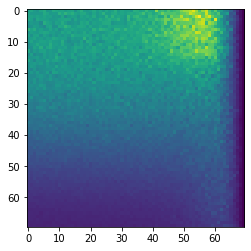

In [ ]:
C = np.zeros((70,70))
t1 = time.time()
dils = np.linspace(0.0, 1.0, num=70)
epss = np.linspace(0.0, 1.0, num=70)
for i,eps in enumerate(epss):
  for j,dil in enumerate(dils):
    dictMes = hlif.runRHNN(eps,dil,250)
    #print(dictMes)
    C[i,j] = dictMes['NClu']
t2 = time.time()
print(t2-t1)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(C)

# Istruzioni invio
./ciclo_HLIF.exe eps dil tau m refr thresh ripe thr

In [ ]:
!time ./ciclo_HLIF.exe 70 70 0 1 0 0.1 250 8


real	40m29.564s
user	78m41.838s
sys	0m7.803s


In [ ]:
2823/60

47.05

In [ ]:
!ls

ciclo_HLIF.cpp	HopfieldLIFGG.ipynb  LIF_lib.cpp
ciclo_HLIF.exe	LIF_cicleGG.ipynb    LIF_lib.h


In [ ]:
#%%timeit
for i in range (3,9):
  th = i/20
  string = " time ./ciclo_HLIF.exe 70 70 0.0 1 0 " + str(th) + " 250 8"
  !eval{string}


real	37m33.058s
user	72m49.017s
sys	0m7.895s

real	37m20.887s
user	72m55.325s
sys	0m8.106s

real	37m41.602s
user	73m25.217s
sys	0m8.198s

real	37m44.187s
user	73m11.013s
sys	0m8.208s


# Codice cpp ciclo_HLIF.cpp

In [ ]:
%%writefile ciclo_HLIF.cpp

// Versione con ricerca sulle mappe (solo per mstati_di_mat, non per statim) e PARALLELIZZAZIONE BUONA

#include <pybind11/pybind11.h>
#include <pybind11/stl_bind.h>
#include <pybind11/numpy.h>

#include <cstdio>
#include <cstdlib>
#include <vector>
#include <array>
#include <ctime>
#include <map>
#include <unordered_map>
#include <algorithm>
#include <iterator>
#include <fstream>
#include <iostream>
#include <iomanip>
#include <thread>
#include <future>
#include <mutex>
#include <assert.h>

#include <cmath>
#include <chrono>
#include <random>

#define HASH_MULT  314159    /* random multiplier */
#define HASH_PRIME 516595003 /* the 27182818th prime; it's $\leq 2^{29}$ */
#define N 14//5//14


using namespace std;

namespace py = pybind11;

using mappa = map<int, unsigned long long int>;


// Definisco le funzioni dichiarate

// # Funzione per calcolare potenze di interi
/* int npow(base, esp) {
    int ret = 1;

    for (int i = 0; i < esp; i++) ret *= base;

    return ret;
} */

// # Funzione per creare la matrice
array<array<double, N>, N> matrice(double eps, double dil) { 
    array<array<double, N>, N>  mat{};
    array<array<double, N>, N>  s_mat(mat);
    array<array<double, N>, N>  a_mat(mat);
    unsigned seed = chrono::system_clock::now().time_since_epoch().count();
    default_random_engine re (seed);
    uniform_real_distribution<double> unif(0,1);
    double a1, a2; 

    for (int i = 0; i < N; i++) {
        for (int j = i + 1; j < N; j++) {
            if (unif(re) > dil){
              a1 = (unif(re) - 0.5) * 2;                         // Gli elementi sono diversi da 0 solo con prob (1-dil)
              s_mat[i][j] = a1;                                  // Creo le due matrici, una simmetrica e una asimmetrica
              s_mat[j][i] = a1;                      
            }
            if (unif(re) > dil) {
              a2 = (unif(re) - 0.5) * 2;
              a_mat[i][j] = a2;
              a_mat[j][i] = -a2;
            }
        }
    }

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++){
            mat[i][j] = (1 - eps / 2) * s_mat[i][j] + (eps / 2) * a_mat[i][j];   // La diagonale viene nulla per costruzione
        }
    }

    return mat;
}

// # Calcolo il prodotto tra matrice e vettore
array<double, N> dot(const array<array<double, N>, N> &mat, const array<int, N> &s) {
    array<double, N> ret{};

    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            ret[i] += mat[i][j] * s[j];
        }
    }

    return ret;
}

// # Calcolo il prodotto tra matrice e vettore composto da 0 e 1
array<double, N> dot01(const array<array<double, N>, N> &mat, const array<int, N> &s) {
    array<double, N> ret{};

    for (int j = 0; j < N; ++j) {
        if (s[j]) {
          for (int i = 0; i < N; ++i) {
              ret[i] += mat[i][j];
          }
        }
    }

    return ret;
}

// # Calcolo il prodotto tra matrice e vettore
array<double, N> dot_vec(const vector<array<double, N>> &pot_vec, const vector<double> &f) {
    array<double, N> ret{};
    int m = f.size();

    for (int i = 0; i < m; ++i) {
        for (int j = 0; j < N; ++j) {
            ret[j] += pot_vec[i][j] * f[i];
        }
    }

    return ret;
}

// # Creo il vettore di decadimento degli stati memorizzati (quanto pesa ogni stato precedente per lo spike attuale)
vector<double> generate_f_k(int m, double tau) {         // f_k ha lunghezza che dipende da m, quindi varia: non posso usare array
    vector<double> f_k(m);

    for (int i = 0; i < m ; i++) {
        f_k[i] = exp(- tau * (m - 1 - i));                  // Gli indici più bassi hanno decadimento maggiore (e quindi un valore più basso). L'ultimo indice ha valore 1 (nessun decadimento)
    }

    return f_k;
}

// # Creo lo stato "n"
array<int, N> s_da_n(int n) {
    array<int, N> s0{};

    for (int i = 0; i < N; i++) {
        s0[N-i-1] = (int(double(n) / (1 << i))) % 2;           // 1<<i è 2**i, calcolato molto velocemente
    }

    return s0;
}

// # Calcolo "n" corrispondente allo stato "s"
int n_da_s(const array<int, N> &s) {
    int ret = 0;

    for (int i = 0; i < N; i++){
        ret += s[i] * (1 << (N - 1 - i));               // Ovvero +=s[i]*2**(N-1-i)
    }

    return ret;
}

// # Ricavo il valore hash di un vettore DA ELIMINARE, NON È PIÙ UTILE
int codif_vect(const vector<int> &vec) {
    int ret = vec.size();

    for (int i = 0; i < ret; i++) {
        ret ^= vec[i] + 0x9e3779b9 + (ret << 6) + (ret >> 2);
    }

    return ret;
}

// # Ottengo il valore hash di un mstato, ottenuto dalla lista degli stati
vector<int> mstato_da_n(const vector<int> &s10, int m) {
    int l = s10.size();

    if (l < m){
        vector<int> s(m-l, 0);
        s.insert(s.end(), s10.cbegin(), s10.cend());
        return s;
    }

    return (vector<int>(s10.cend() - m, s10.cend()));
}

// # Calcolo della media da una mappa
double mean_dic(const map<int, unsigned long long int> &a) {
    double sum = 0, dot = 0;
    for (map<int, unsigned long long int>::const_iterator it = a.cbegin(); it != a.cend(); ++it) {
        sum += it->second;
        dot += it->first * it->second;
    }

    return dot / sum;
}

// # Calcolo della deviazione standard da una mappa
double std_dic(const map<int, unsigned long long int> &a) {
    double sum = 0, dot = 0, dotsq = 0;
    for (map<int, unsigned long long int>::const_iterator it = a.cbegin(); it != a.cend(); ++it) {
        sum += it->second;
        dot += it->first * it->second;
        dotsq += (it->first) * (it->first) * it->second;
    }

    dot /= sum;
    dotsq /= sum;

    return sqrt(dotsq - (dot * dot));
}

// # Calcolo della media da una mappa
double mean_dic(const unordered_map<int, unsigned long long int> &a) {
    double sum = 0, dot = 0;
    for (unordered_map<int, unsigned long long int>::const_iterator it = a.cbegin(); it != a.cend(); ++it) {
        sum += it->second;
        dot += it->first * it->second;
    }

    return dot / sum;
}

// # Calcolo della deviazione standard da una mappa
double std_dic(const unordered_map<int, unsigned long long int> &a) {
    double sum = 0, dot = 0, dotsq = 0;
    for (unordered_map<int, unsigned long long int>::const_iterator it = a.cbegin(); it != a.cend(); ++it) {
        sum += it->second;
        dot += it->first * it->second;
        dotsq += (it->first) * (it->first) * it->second;
    }

    dot /= sum;
    dotsq /= sum;

    return sqrt(dotsq - (dot * dot));
}

template <typename T>
class VectHash {
    public:
    long int operator()(const vector<T> &vec) const {
      long int orig_index = 0;
      for (unsigned int l = 0; l < vec.size(); ++l) {
          const unsigned char *buf = reinterpret_cast<const unsigned char*>(&vec[l]);            // Interpreto i byte in memoria dell'elemento l del vettore come array di unsigned char
          for (unsigned int i = 0; i < sizeof(T); i++, buf++) {                          // Seguo lalgoritmo di Donald Knutt
            orig_index += (orig_index ^ (orig_index >> 1)) + HASH_MULT * (*buf);
            while (orig_index >= HASH_PRIME) orig_index -= HASH_PRIME;
          }
          //index = orig_index % capacity;
      }
      return orig_index;
    }
};

//void ciclo_singola_matrice(double eps, double dil, int m, int refr, double thresh, const vector<double> &f_k, mappa *isto_dist, mappa *isto_dmax, mappa *isto_lung, mappa *isto_size, mappa *isto_nclu, mappa *isto_nvic, int ripetiz = 1);
//mutex mtx;
//
//int main(int argc, char *argv[]){
//    if (argc < 9) {                                  // Messaggio di errore se si lancia il programma senza argomenti
//        fprintf(stderr, "SYNTAX ERROR: %s eps, dil, tau, m, refr, thresh, ripe, thr:\n"
//        "\t      - epsilon density (quante eps generare)\n"
//        "\t      - dilution density (quante dil generare)\n"
//        "\t      - tau (double; reciproco del tempo caratteristico di decadimento)\n"
//        "\t      - m (int; numero di tempi precedenti considerati)\n"
//        "\t      - refrattario (int; 1 se si vuole il periodo refrattario, 0 altrimenti)\n"
//        "\t      - threshold (double; threshold di attivazione)\n"
//        "\t      - ripetizioni (int; numero ripetizioni per matrice)\n"
//        "\t      - thr (int; numero di threads)\n", argv[0]);
//        return EXIT_FAILURE;
//    }
//    int n_eps = atof(argv[1]);                       // Dichiaro gli argomenti passati al .exe, spiegati nel messaggio di errore
//    int n_dil = atof(argv[2]);
//    double tau = atof(argv[3]);
//    int m = atoi(argv[4]);
//    int refr = atoi(argv[5]);
//    double thresh = atof(argv[6]);
//    int ripe = atoi(argv[7]);
//    int thr = atoi(argv[8]);
//    
//    double eps = 0.0;
//    double dil = 0.0;
//
//    vector<double> f_k = generate_f_k(m, tau);        // Vettore dei decadimenti
//    
//    int n_threads = thread::hardware_concurrency();
//    n_threads = n_threads < thr ? n_threads : thr;
//    int passi = int((double)(ripe + n_threads - 1) / n_threads);        // numero di batch parallelizzati 
// 
//    ofstream osd, oss, osl, osc;
//    string path = "/content/drive/My Drive/";
//    string file_D = path + "D_N=" + to_string(N) + "_Ne=" + to_string(n_eps)+ "_Nd=" + to_string(n_dil) + "_tau=" + to_string(tau) + "_m=" + to_string(m) + "_refr=" + to_string(refr) + "_thresh=" + to_string(thresh) + "_ripe=" + to_string(ripe) + ".dat" ;
//    string file_S = path + "S_N=" + to_string(N) + "_Ne=" + to_string(n_eps)+ "_Nd=" + to_string(n_dil) + "_tau=" + to_string(tau) + "_m=" + to_string(m) + "_refr=" + to_string(refr) + "_thresh=" + to_string(thresh) + "_ripe=" + to_string(ripe) + ".dat" ;
//    string file_L = path + "L_N=" + to_string(N) + "_Ne=" + to_string(n_eps)+ "_Nd=" + to_string(n_dil) + "_tau=" + to_string(tau) + "_m=" + to_string(m) + "_refr=" + to_string(refr) + "_thresh=" + to_string(thresh) + "_ripe=" + to_string(ripe) + ".dat" ;
//    string file_C = path + "C_N=" + to_string(N) + "_Ne=" + to_string(n_eps)+ "_Nd=" + to_string(n_dil) + "_tau=" + to_string(tau) + "_m=" + to_string(m) + "_refr=" + to_string(refr) + "_thresh=" + to_string(thresh) + "_ripe=" + to_string(ripe) + ".dat" ;
//    osd.open(file_D);
//    oss.open(file_S);
//    osl.open(file_L);
//    osc.open(file_C);
//    
//    for (int e = 0; e < n_eps+1; ++e) {
//        eps = (double) e / n_eps;
//        for (int d = 0; d < n_dil; ++d) {
//            dil = (double) d / n_dil;
//            
//            
//            mappa isto_dist;                                  // Rappresento gli istogrammi come mappe
//            mappa isto_dmax;
//            mappa isto_lung;
//            mappa isto_size;
//            mappa isto_nclu;
//            mappa isto_nvic;
//            
//            vector<future<void>> threads;
//            for (int i_thr = 0; i_thr < n_threads; ++i_thr) threads.emplace_back(async(std::launch::async, ciclo_singola_matrice, eps, dil, m, refr, thresh, f_k, &isto_dist, &isto_dmax, &isto_lung, &isto_size, &isto_nclu, &isto_nvic, passi));
//        
//            for (auto &a : threads) a.wait();
//            
//            osd << mean_dic(isto_dist) << "\t";
//            oss << mean_dic(isto_size) << "\t";
//            osl << mean_dic(isto_lung) << "\t";
//            osc << mean_dic(isto_nclu) << "\t";
//            osd.flush();
//            oss.flush();
//            osl.flush();
//            osc.flush();
//        }
//        
//        osd << "\n";
//        oss << "\n";
//        osl << "\n";
//        osc << "\n";
//        
//    }
//    
//    osd.close();
//    oss.close();
//    osl.close();
//    osc.close();
//    
//    return 0;
//}


void ciclo_singola_matrice(double eps,
                           double dil,
                           int m,
                           int refr, 
                           double thresh,
                           const vector<double> &f_k,
                           mappa *isto_dist,
                           mappa *isto_dmax,
                           mappa *isto_lung,
                           mappa *isto_size,
                           mappa *isto_nclu,
                           mappa *isto_nvic,
                           int ripetiz,
                           bool loadNets,
                           double* nets) {
  array<array<double, N>, N> mat;
  for (int rip = 0; rip < ripetiz; ++rip) {
        //py::print("loadNet",loadNets);
        if(loadNets == false){
            mat = matrice(eps, dil);     // Matrice delle connessioni
        }else{
            for (unsigned int j = 0; j<N;++j){
              for (unsigned int i= 0; i<N;++i){
                mat[i][j] = nets[i+j*N+rip*N*N];
              }    
            }
        }

        //for (unsigned int j=0; j<N;++j){
        //  py::list line;
        //  for (unsigned int i = 0; i < N; ++i) {
        //    line.append(mat[i][j]);
        //  }
        //  py::print(j,line);
        //}
	      

        int icluster = 0;                                       // Contatore dei cluster
        unordered_map<vector<int>, int, VectHash<int>> mstati_di_mat{};                 // Lista degli mStati della matrice
        vector<int> charact{};                                  // Carattere degli mStati della matrice (1 inizio, 2 transiente, 3 ciclo limite)
        vector<int> cluster{};                                  // Cluster degli mStati
        vector<int> dist{};                                     // Distanza dal C.L. degli mStati
        vector<int> nvic{};                                     // Numero di mStati che evolvono in un certo mStato
    
        for (int n = 0; n < (1 << N); ++n) {                      // Ciclo sui 2^N stati iniziali
           vector<int> stati10(1, n);                           // Lista degli stati singoli di una condiz iniziale, in base 10
           //py::print("stati10",stati10[0]);
           vector<int> mstato_k = mstato_da_n(stati10, m);      // Primo mStato
           //py::list vec;
           //for (unsigned int i=0; i<m;++i) vec.append(mstato_k[i]);
           //py::print("vec",vec);
           
           if (mstati_di_mat.find(mstato_k) != mstati_di_mat.end()) continue;  //  Controllo che uno stato come quello iniziale (ovvero [0,0...0, n]) non sia già comparso

           mstati_di_mat[mstato_k] = mstati_di_mat.size();      // Aggiungo alla mappa il nuovo vettore e l'indice corrispondente (ovvero la lunghezza della mappa)
           charact.push_back(1);
           nvic.push_back(0);

           int t = 0;                                                     // Contatore del tempo del processo
           array<int, N> s = s_da_n(n);                                   // Stato come vettore di attivazione dei neuroni
           //py::list vec;
           //for (unsigned int i=0; i<N;++i) vec.append(s[i]);
           //py::print("vec",vec);
           array<int, N> refr_s{};                                        // Array che conta quanti tempi dura ancora il refr di un neurone
           vector<array<double, N>> pot_memorizz(m, array<double, N>{});  // Lista dei potenziali degli m stati (stato attuale + m-1 precedenti)
           pot_memorizz.back() = dot(mat, s);                             // Per lo stato iniziale assumo che gli stati precedenti fossero tutti 0. .back() mi da l'ultimo elemento
           array<double, N> v;
           unsigned int indice, prima_comparsa, k;

           while (true) {
               t += 1;                                                    // Lo aggiorno subito perchè nello 0 dele liste già ho messo lo stato iniziale (quindi voglio che alla prima iterazione valga 1)

              if (refr > 0) {
                  for (int i = 0; i < N; ++i){
                      if (refr_s[i] > 0) {                                    // Se il conto alla rovescia del suo periodo refrattario non è ancora a 0
                          refr_s[i] -= 1;                                     // Aggiorno il conto alla rovescia
                          pot_memorizz[m-1][i] = 0;                           // Azzero il suo ultimo potenziale (gli altri saranno già nulli per costduzione)
                      } else if (s[i]==1){                                       // Se invece si è appena attivato, annullo le ultime m memorie
                          for (int j = 0; j < m; ++j) {
                              refr_s[i] = refr - 1;
                              pot_memorizz[j][i] = 0;
                          }
                      }
                  }
              }
               
               v = dot_vec(pot_memorizz, f_k);
               for (int i = 0; i < N; ++i) {
                   s[i] = v[i] >= thresh;                                        // Theta di Heavyside per ogni elemento di v, che ci da s
               }  

               for (int i = 0; i < m-2; ++i) {                             // Levo dai pot. memorizzati il pot più vecchio e aggiungo il più nuovo 
                   pot_memorizz[i] = pot_memorizz[i + 1];
               }
               pot_memorizz[m-1] = dot(mat, s);

               k = n_da_s(s);                                              // Ricavo il valore decimale corrispondente allo stato
               //py::print(">k",k);
               //py::list vec;
               //for (unsigned int i=0; i<N;++i) vec.append(s[i]);
               //py::print("vec",vec);

               stati10.push_back(k);                                       // Aggiorno gli stati decimali  
               mstato_k = mstato_da_n(stati10, m);                         // Ricavo il valore codificato del mStato    

               auto it_indice = mstati_di_mat.find(mstato_k);              //  Cerco se questo stato è già comparso per questa matrice; distance mi da la posizione, se lo trova, del valore. Altrimenti mi da la fine della mappa

               if (it_indice == mstati_di_mat.end()) {                     // Ovvero se non è stato trovato: non è mai comparso. Lo aggiungo alle liste (vicini, carattere, mStati) 
                  nvic.push_back(1);
                  charact.push_back(2);
                  mstati_di_mat[mstato_k] = mstati_di_mat.size();                  
               } else if (cluster.size() <= (indice = it_indice->second)) {    // Ovvero se esiste in questo percorso. Controllo se l'indice di mStati_di_mat esiste anche in cluster
                  icluster += 1;
                  nvic[indice] += 1;
                  prima_comparsa = indice - cluster.size();                      //  Dove è già comparso in questo percorso. Escludo l'ultimo stato dalla ricerca, così ottengo un solo numero
                  cluster.insert(cluster.end(), t, icluster);                    //  Gli stati di questo cluster sono gli ultimi t stati aggiunti a mstati_di_M (quelli del percorso di questa cond. iniziale), quindi i loro indici sono gli ultimi t
                  for (int i = prima_comparsa; i > 0; --i) dist.push_back(i);    // Le distanze dal ciclo (elementi fuori dal ciclo)
                  dist.insert(dist.end(), (t - prima_comparsa), 0);              // Distanze (nulle) degli elementi nel ciclo
                  fill(charact.end() - t + prima_comparsa, charact.end(), 3);    // Li caratterizzo come cicli
                  break;
               } else {                                                                         
                  nvic[indice] += 1;                                             // Ovvero se esiste in mstati_di_mat e non in questo percorso                     
                  cluster.insert(cluster.end(), t, cluster[indice]);                                  
                  for (int i = t; i > 0; --i) dist.push_back(i + dist[indice]);                          
                  break;
               }
           }
        }
        
        //mtx.lock();
        for (int i = 0; i < (1<<N); ++i) {                                  
            (*isto_nvic)[nvic[i]] += 1;                                        
            (*isto_dist)[dist[i]] += 1;                                        
            if (charact[i] == 1) (*isto_dmax)[dist[i]] += 1;                   
        }

        for (int i = 1; i < icluster+1; ++i) {
            int lunghezza = 0, bacino = 0;
            for (unsigned int j = 0; j < charact.size(); ++j) {
                lunghezza += ((cluster[j]==i) && (charact[j]==3));       // se lo stato j appartiene al cluster e ha carattere 3, è cl
                bacino += (cluster[j] == i);
            }
            (*isto_lung)[lunghezza] += 1;
            (*isto_size)[bacino] += 1;
        }

        (*isto_nclu)[icluster] += 1;
        //mtx.unlock();
  }
}


py::dict runRHNN(double eps, double dil,int ripetiz = 1000){
  mappa isto_dist;                                  // Rappresento gli istogrammi come mappe
  mappa isto_dmax;
  mappa isto_lung;
  mappa isto_size;
  mappa isto_nclu;
  mappa isto_nvic;

  py::dict dict_measures;

  double *ptrNet;
  //ptrNet[0] = 0;
  //double eps = 0.0;
  //double dil = 0.0;
  py::print("N",N,"eps",eps, "dil",dil,"ripetiz",ripetiz);
  int m = 1;
  int refr = 0; 
  double thresh = 0.1;
  double tau = 1.0;
  vector<double> f_k = generate_f_k(m, tau);        // Vettore dei decadimenti
  //int ripetiz = 1;

  ciclo_singola_matrice(eps, dil, m, refr, thresh, f_k,
                        &isto_dist, &isto_dmax, &isto_lung, &isto_size, &isto_nclu, &isto_nvic,
                        ripetiz, false, ptrNet);

  // Calcola medie
  double meanDist = mean_dic(isto_dist);
  double meanSize = mean_dic(isto_size);
  double meanLung = mean_dic(isto_lung);
  double meanNClu = mean_dic(isto_nclu);
  //mettile nel dizionario
  dict_measures["Dist"] = meanDist;
  dict_measures["Size"] = meanSize;
  dict_measures["Lung"] = meanLung;
  dict_measures["NClu"] = meanNClu;

  return dict_measures;
}

py::dict runRHNNwithNets(double thresh, py::array_t<double> net){
  
  py::buffer_info bufNet = net.request();
  double *ptrNet = (double *) bufNet.ptr;
	unsigned int Np = (unsigned int) bufNet.shape[2];
	unsigned int Npp = (unsigned int)  bufNet.shape[1];
	unsigned int ripetiz = (unsigned int) bufNet.shape[0];
  py::print("N",Np);
  py::print("Np",Npp);
  assert (N==Np);
  assert (N==Npp);
  py::print("ripetiz",ripetiz);

  //for (unsigned int k=0; k<ripetiz;++k){
  //  for (unsigned int j=0; j<N;++j){
  //    py::list line;
  //    for (unsigned int i = 0; i < N; ++i) {
  //      line.append(ptrNet[i+j*N+k*N*N]);
  //      //py::print(i,j,k,ptrNet[i+j*N+k*N*N]);
  //    }
  //    py::print(j,k,line);
  //  }
	//}
  
  mappa isto_dist;                                  // Rappresento gli istogrammi come mappe
  mappa isto_dmax;
  mappa isto_lung;
  mappa isto_size;
  mappa isto_nclu;
  mappa isto_nvic;

  py::dict dict_measures;


  //double eps = 0.0;
  //double dil = 0.0;
  py::print("N",N,"thresh",thresh,"ripetiz",ripetiz);
  int m = 1;
  int refr = 0; 
  //double thresh = 0.1;
  double tau = 1.0;
  vector<double> f_k = generate_f_k(m, tau);        // Vettore dei decadimenti
  //int ripetiz = 1;

  ciclo_singola_matrice(0.0, 0.0, m, refr, thresh, f_k,
                        &isto_dist, &isto_dmax, &isto_lung, &isto_size, &isto_nclu, &isto_nvic,
                        ripetiz,true,ptrNet);

  // Calcola medie
  double meanDist = mean_dic(isto_dist);
  double meanSize = mean_dic(isto_size);
  double meanLung = mean_dic(isto_lung);
  double meanNClu = mean_dic(isto_nclu);
  //mettile nel dizionario
  dict_measures["Dist"] = meanDist;
  dict_measures["Size"] = meanSize;
  dict_measures["Lung"] = meanLung;
  dict_measures["NClu"] = meanNClu;

  return dict_measures;
}

PYBIND11_MODULE(hlif, m) {
    m.doc() = "run recurrent hopfield neural network"; // optional module docstring
    m.def("runRHNN", &runRHNN, "Runs recurrent neural network");
    m.def("runRHNNwithNets", &runRHNNwithNets, "Runs recurrent neural network with a array of connettivity matrices");
}

Overwriting ciclo_HLIF.cpp
